# Image Caption Imputation with Few-Shot Learning
## 1. Introduction
In this notebook, I will use GPT-4 to predict the image caption for images/videos that were not able to be processed.

In [1]:
!pip install openai -q

In [2]:
import io
import json
import time
import boto3
import gzip
import pandas as pd

## 2. Load and Prep Data
Read in the DynamoDB export from S3. This is a `json.gz` file, so I will need to decompress it first.

In [3]:
# Initialize S3 client
s3_client = boto3.client('s3')
bucket_name = 'sagemaker-us-east-1-513033806411'
prefix = 'reddit/funny/AWSDynamoDB/01707772823868-594c64db/data/'

# List all objects in the specified S3 bucket path
objects = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

dataframes = []  # List to hold the DataFrames

if 'Contents' in objects:
    for obj in objects['Contents']:
        key = obj['Key']
        # Check if the file is a .json.gz file
        if key.endswith('.json.gz'):
            # Get the object from S3
            response = s3_client.get_object(Bucket=bucket_name, Key=key)
            content = response['Body'].read()

            # Decompress and read into a pandas DataFrame
            with gzip.GzipFile(fileobj=io.BytesIO(content)) as gzipfile:
                content = gzipfile.read()

            df = pd.read_json(io.BytesIO(content), lines=True)  # Assuming the JSON is line-delimited
            dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dataframes, ignore_index=True)

In [4]:
# Define your schema keys and types
schema_keys = ['submissionId', 'topComment', 'blipCaption', 'numComments', 
               'topCommentScore', 'createdUtc', 'score', 'imageS3Url', 
               'url', 'body', 'title', 'textRekognition', 'celebrityRekognition']

# Function to extract and convert values based on the schema
def extract_and_convert(row):
    # Initialize a dictionary to hold the extracted values
    extracted = {}
    for key in schema_keys:
        # Check if the key exists in the row and extract the value
        if key in row and 'S' in row[key]:
            extracted[key] = row[key]['S']  # Handle string values
        elif key in row and 'N' in row[key]:
            # Convert numeric values to float or int as needed
            try:
                # Attempt to convert to int, fall back to float if necessary
                extracted[key] = int(row[key]['N'])
            except ValueError:
                extracted[key] = float(row[key]['N'])
        else:
            # Assign a default value (None) if the key is missing
            extracted[key] = None
    return extracted

# Apply the transformation to each row in the DataFrame and create a new DataFrame
df_transformed = pd.DataFrame(list(final_df['Item'].apply(extract_and_convert)))

Let's make sure there aren't any deleted top comments in the training set.

In [5]:
# check for deleted top comments
deleted_comments = df_transformed[df_transformed['topComment'] == '[deleted]'].shape[0]
print(f"Deleted Top Comments: {deleted_comments}")

Deleted Top Comments: 70


In [6]:
# drop [deleted]
df_transformed = df_transformed[df_transformed['topComment'] != '[deleted]'].reset_index(drop=True)

Inspect submissions with a body in the post. There are only a handful, so we can manually drop those that do not add value

In [9]:
# inspect submissions with a body in the post
df_transformed.loc[df_transformed['body'] != '','body']

104                                   Credit @Philmhanley
193     I need some good material so he remembers me a...
423                                                     😅
663     Taken from NDTV news outlet who reported this:...
947                             How long did it take you?
1061                               They must have known….
1239                                    It ain’t even hot
1287    On July 1st, 2023, Reddit intends to alter how...
1764                                Self defense skills\n
1793                              This is from Brooklyn99
1934    It’s making me type something here before it w...
2147                     It couldn’t have gone any worse 
2289    [ Removed by reddit in response to a copyright...
2409                               Credit: @hassankhadair
2421    I finished my business and washed my hands bef...
2463    If it had been mine, my parents would have bee...
2465                                                   \n
2508    I made

In [7]:
# manually clean up body
drop_body = [104,423,1287,1934,2289,2409,2465]
df_transformed.loc[drop_body,'body'] = ''

There are some image urls that point to missing images. These are captured by Amazon text Rekogntion, so we can check for that with the logic below. Here's an example below where Rekognition returns **"The image you are requesting does not exist"**

In [11]:
df_transformed.iloc[372,:]

submissionId                                                       ycikjv
topComment              Put up Lost "Dog" posters around the neighborh...
blipCaption             a black and white photo of a person with a quo...
numComments                                                          1042
topCommentScore                                                      7578
createdUtc                                                     1666635749
score                                                              130921
imageS3Url              s3://sagemaker-us-east-1-513033806411/reddit/f...
url                                       https://i.imgur.com/u5ocTE9.png
body                                                                     
title                   A tree fell on my fence. Making the best of it...
textRekognition         The image you are re que sting does not exist ...
celebrityRekognition                                                     
Name: 372, dtype: object

In [8]:
# clean missing images
df_transformed['image_does_not_exist'] = df_transformed['textRekognition'].str.contains('does not exist', na=False)

In [9]:
missing_images = df_transformed[df_transformed['image_does_not_exist'] == True].shape[0]
print(f"Missing Images: {missing_images}")

Missing Images: 9


I will drop these submissions and add them to the cohort of submissions whose descriptions will be imputed.

In [10]:
# replace values
replace_cols = ['blipCaption','textRekognition','celebrityRekognition']
df_transformed.loc[df_transformed['image_does_not_exist'] == True, replace_cols] = (None, None, None)

In [11]:
# combine title and body
df_transformed['title'] = df_transformed.apply(lambda row: row['title'] + '\n' + row['body'] if row['body'] != '' else row['title'], axis=1)

## 3. Prompt Engineering
Now the data is ready for imputation with GPT-4. Let's split the data into a dataframe for those with image captions populated, `caption_df`, and those to be imputed, `impute_df`.

In [12]:
# split datasets
use_cols = ['submissionId','title','blipCaption','textRekognition',
                      'celebrityRekognition','topComment']
caption_df = df_transformed.loc[~df_transformed['blipCaption'].isna(), use_cols].reset_index(drop=True)
impute_df = df_transformed.loc[df_transformed['blipCaption'].isna(), use_cols].reset_index(drop=True)

### a) Example Post
Let's look at an example from `caption_df` to see how the model interpets the image.

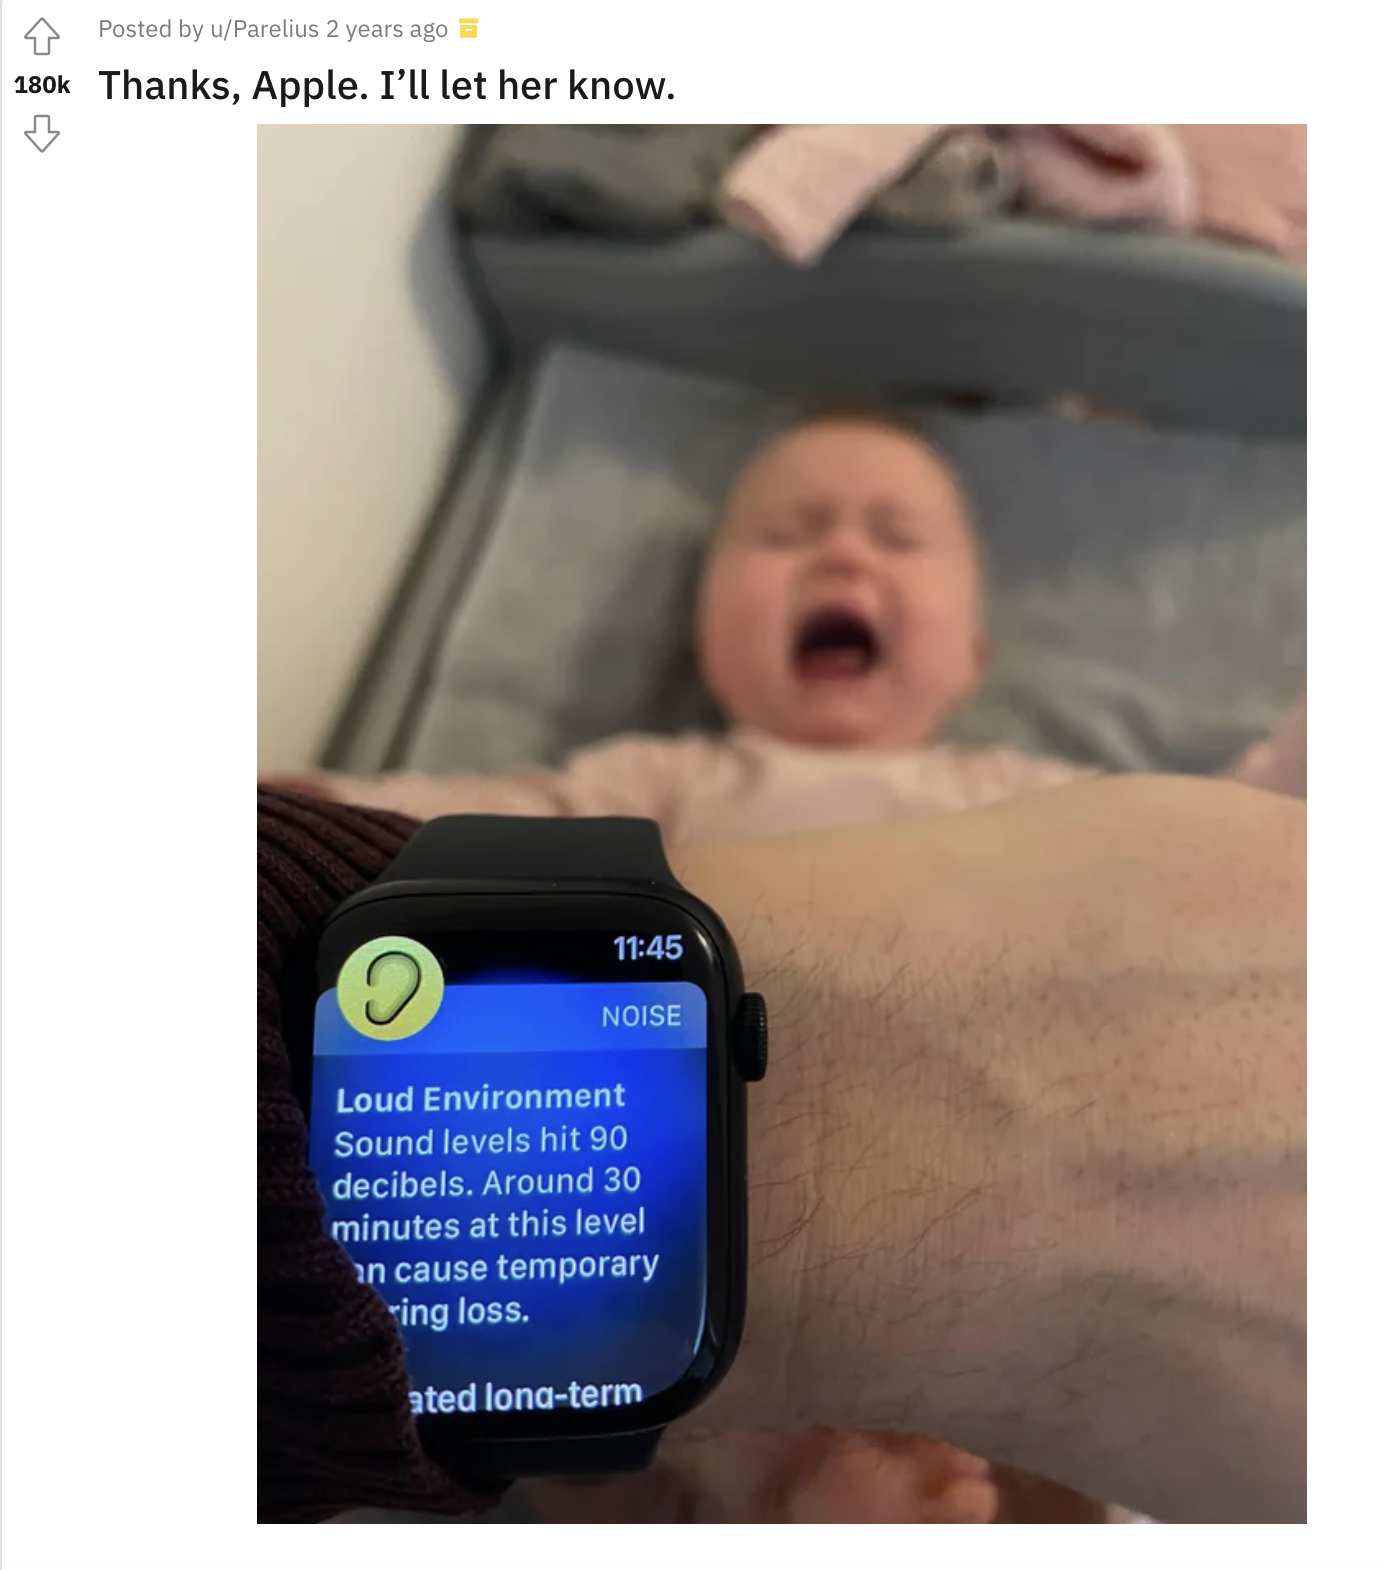

In [6]:
from IPython.display import Image
Image(filename='./images/apple-watch.png')

In [17]:
caption_df[caption_df["title"] == "Thanks, Apple. I’ll let her know."]

,submissionId,title,blipCaption,textRekognition,celebrityRekognition,topComment
474,sxr3y9,"Thanks, Apple. I’ll let her know.",someone is holding a smart watch with a baby i...,11:45 I NOISE Loud Environment Sound levels hi...,,Look on the bright side. In 30 mins it'll seem...


In [19]:
def get_info(i):
    print(caption_df.loc[i,'submissionId'])
    print(f"\nTitle: {caption_df.loc[i,'title']}")
    print(f"\nTop Comment: {caption_df.loc[i,'topComment']}")
    print(f"\nDescription: {caption_df.loc[i,'blipCaption']}")
    print(f"\nText: {caption_df.loc[i,'textRekognition']}")
    print(f"\nCelebrities: {caption_df.loc[i,'celebrityRekognition']}")
    
get_info(474)

sxr3y9

Title: Thanks, Apple. I’ll let her know.

Top Comment: Look on the bright side. In 30 mins it'll seem quieter!

Description: someone is holding a smart watch with a baby in the background

Text: 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term

Celebrities: 


**Takeaway:** The image captioning model perfectly depicts what is happening in the picture. Amazon Rekognition detects accurately detects all of the visible text and doesn't detect any celebrities, which is good because there are none. One challenge is the person's sleeve is obstructing the full view of the text on the apple watch. For a human it's easy to guess what it might say. However, this could be confusing for an LLM.

Seeing this example helps frame how I'm going to construct the prompt to try to impute the missing image data. Now let's set up the connection with OpenAI.

### b) Initialize OpenAI Client

In [20]:
def get_secret():

    secret_name = "reddit_scraper"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']

    return json.loads(secret)

In [21]:
from openai import OpenAI

secret = get_secret()
client = OpenAI(
    api_key=secret['openai_api_key'],
)

### c) Construct Prompt
To get the desired performance, I provide some general instructions along with four examples. This technique is called *"Few-shot learning"*

In [44]:
system_prompt = """I am analyzing a dataset of Reddit submissions, each with a title, a top comment, and an associated image. For each submission, I need to generate a detailed description of the missing image, identify any text visible in the image, and name any celebrities present based on the context provided by the title and top comment. Below are examples of completed entries for reference:
---------------------------------------
### Example 1:
- Title: Immortal Keanu Reeves
- Top Comment: Keanu Reeves will never die
- Description: a series of pictures of a man with a beard and a beard
- Text: 1875 1530 2011 1994 2008 2077 1875 1530 2011 1994 2008 2077
- Celebrities: Keanu Reeves, Keanu Reeves, Keanu Reeves, Paul Mounet

### Example 2:
- Title: Thanks, Apple. I’ll let her know.
- Top Comment: Look on the bright side. In 30 mins it'll seem quieter!
- Description: someone is holding a smart watch with a baby in the background
- Text: 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term
- Celebrities: 

### Example 3:
- Title: The most suspicious looking technician at today's SpaceX launch...
- Top Comment: “He’s not supposed to be there”
- Description: A bearded male doctor in white lab coat and glasses standing in front of a glass wall
- Text: 
- Celebrities: Jake Busey

### Example 4:
- Title: In Minnesota, we like to play a game called "am I on the road?"
- Top Comment: The first person to drive on a snowy road gets to determine where the lanes are.
- Description: Snowy road with cars driving on it in the middle of the night
- Text: Speed Limit 40
- Celebrities: 
---------------------------------------
Based on the information above, generate a detailed description for the following submission, identify any visible text, and name any celebrities present:

- Title: [Input Title Here]
- Top Comment: [Input Top Comment Here]

Your output should include a detailed description of what is likely depicted in the image, any text that might be visible, and identify any celebrities that could logically be inferred from the context provided.
"""

### d) Test Prompt
Let's test our prompt and GPT-4's ability to generate a good description given the `Title` and `Top Comment`

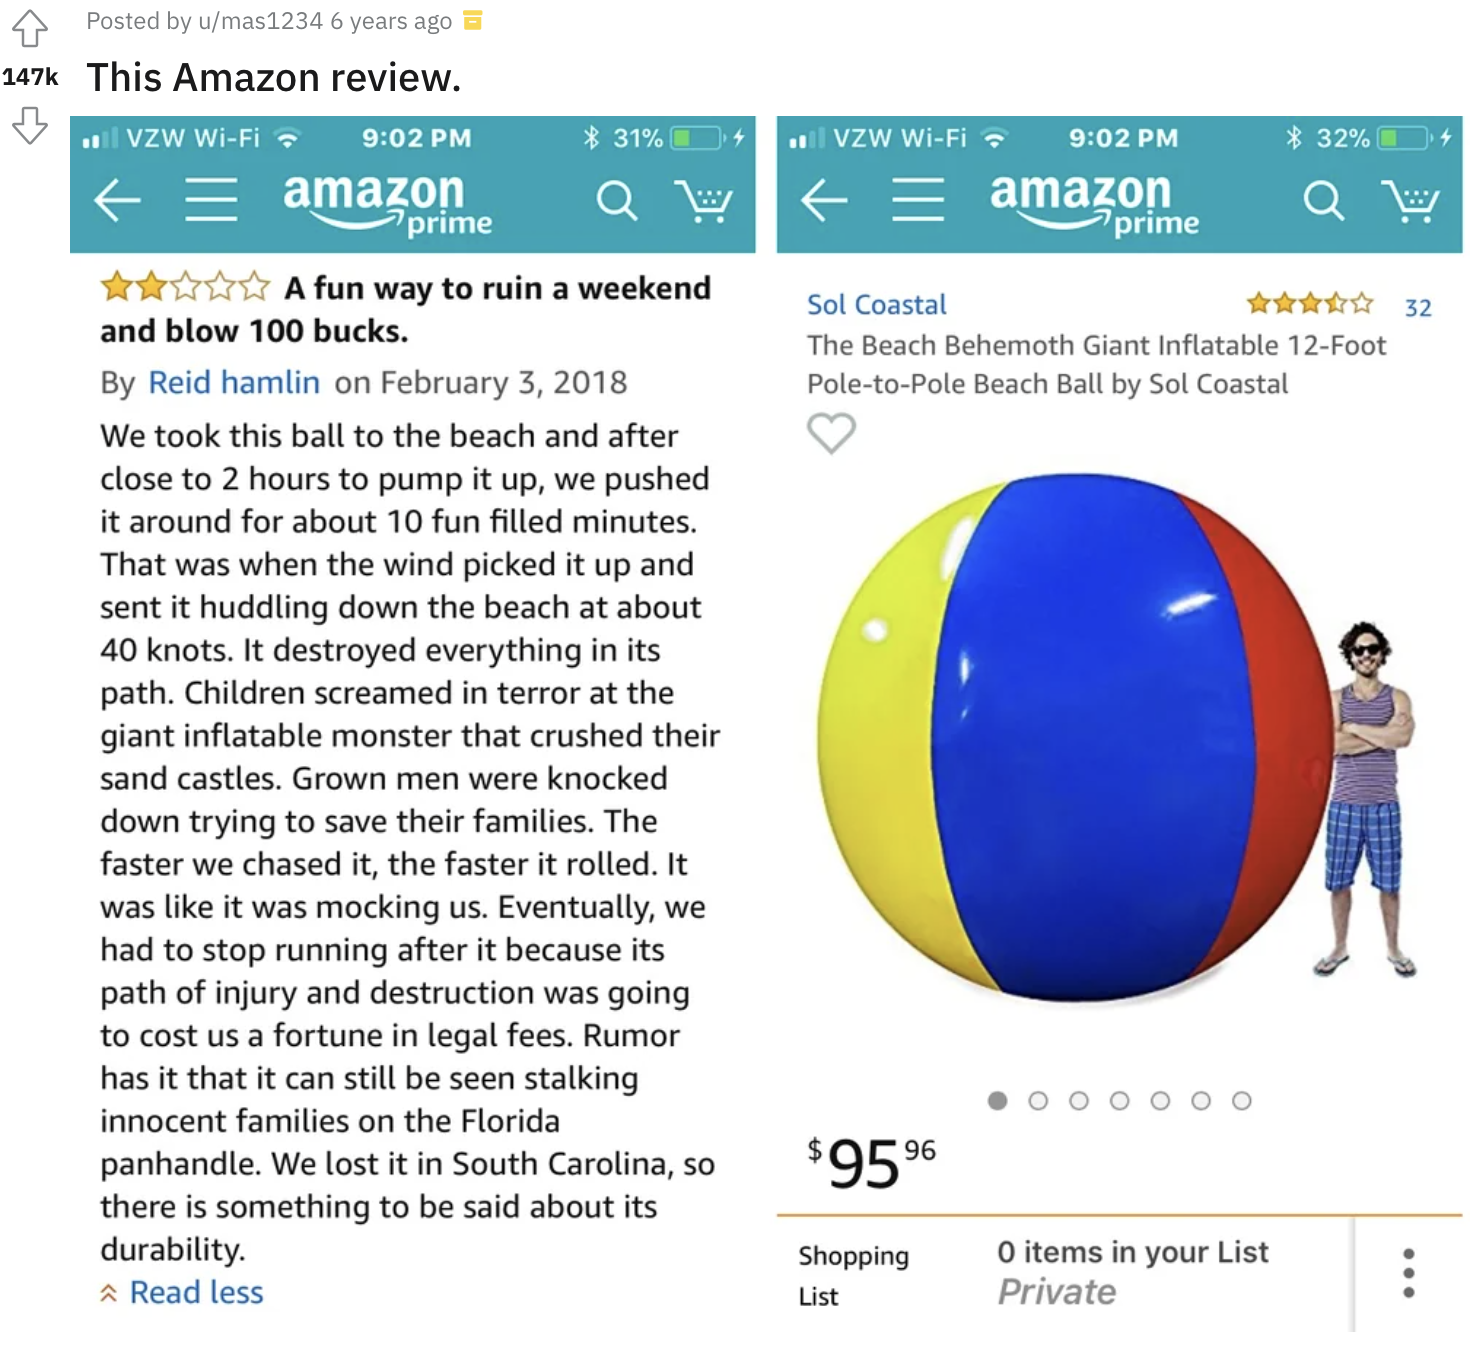

In [7]:
Image(filename='./images/amazon-review.png')

#### Actual Description from `BLIP` and `Rekognition`

In [23]:
# Test Example - Amazon Beach Ball Review
get_info(37)

7vfxix

Title: This Amazon review.

Top Comment: I have one of these. Only takes 20 minutes to blow up if you have an electric pump. Can confirm is fun, and also a pain in the ass to control and store. Overall I wish it was a little bit taller, I wish it was a baller, I wish I had a girl who looked good, I would call her.

Edit: [Pics or it didn't happen]( https://i.imgur.com/qFS6rOhh.jpg)

Description: someone is buying a beach ball for $ 2 99

Text: vzw Wi-Fi 9:02 PM 31% vzw Wi-Fi 9:02 PM 32% amazon amazon III prime prime A fun way to ruin a weekend Sol Coastal 32 and blow 100 bucks. The Beach Behemoth Giant Inflatable 12-Foot By Reid hamlin on February 3, 2018 Pole-to-Pole Beach Ball by Sol Coastal We took this ball to the beach and after close to 2 hours to pump it up, we pushed it around for about 10 fun filled minutes. That was when the wind picked it up and sent it huddling down the beach at about 40 knots. It destroyed everything in its path. vzw Wi-Fi 9:02 PM 31% vzw Wi-Fi 9:0

#### Predicted Description from `GPT-4`

In [24]:
user_input = """- Title: This Amazon review.
- Top Comment: I have one of these. Only takes 20 minutes to blow up if you have an electric pump. Can confirm is fun, and also a pain in the ass to control and store. Overall I wish it was a little bit taller, I wish it was a baller, I wish I had a girl who looked good, I would call her.\n\nEdit: [Pics or it didn't happen]( https://i.imgur.com/qFS6rOhh.jpg)
- Description: {DESCRIPTION}
- Text: {TEXT}
- Celebrities: {CELEBRITIES}
"""

In [43]:
# OpenAI 
messages = [{"role": "system", "content": system_prompt},
                {"role":"user", "content": user_input}]

response = client.chat.completions.create(
        model= 'gpt-4-turbo-preview',
        messages= messages,
        temperature = 0.2,
        max_tokens = 500,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0)

print(response.choices[0].message.content)

### Description:
The image likely shows a screenshot of an Amazon review for a large inflatable product, possibly a ball or another type of recreational inflatable item. The review is humorously detailed, mentioning the ease of inflation with an electric pump and the fun yet challenging aspects of controlling and storing the item. The review may also include a whimsical wish list, echoing the lyrics of a well-known song, suggesting the reviewer wishes the product was larger and segueing into a playful desire for personal improvements and companionship. The background or surrounding content in the screenshot might include the typical Amazon review layout, with a star rating, the product's title, and possibly other customer reviews or related products visible.

### Text:
Given the context, the text in the image would include the review itself, which might read something like: "Only takes 20 minutes to blow up if you have an electric pump. Can confirm is fun, and also a pain in the ass to

#### This is pretty good, but it looks like I need some tighter reigns on the prompt. Let's make some adjustments:

### e) Test Prompt Adjustments

I'm changing the wording of `"detailed"` description to `"brief"` description and added the line: 
`"It is very important that you follow the notation in the provided examples. Be succinct with the description. For text and celebrities, only include text or celebrities that might be included in the images. Otherwise, these fields should be left null. Do not include your reasoning, only the required information."`

In [46]:
system_prompt = """I am analyzing a dataset of Reddit submissions, each with a title, a top comment, and an associated image. For each submission, I need to generate a detailed description of the missing image, identify any text visible in the image, and name any celebrities present based on the context provided by the title and top comment. Below are examples of completed entries for reference:
---------------------------------------
### Example 1:
- Title: Immortal Keanu Reeves
- Top Comment: Keanu Reeves will never die
- Description: a series of pictures of a man with a beard and a beard
- Text: 1875 1530 2011 1994 2008 2077 1875 1530 2011 1994 2008 2077
- Celebrities: Keanu Reeves, Keanu Reeves, Keanu Reeves, Paul Mounet

### Example 2:
- Title: Thanks, Apple. I’ll let her know.
- Top Comment: Look on the bright side. In 30 mins it'll seem quieter!
- Description: someone is holding a smart watch with a baby in the background
- Text: 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term 11:45 I NOISE Loud Environment Sound levels hit 90 decibels. Around 30 minutes at this level n cause temporary ring loss. ated lona-term
- Celebrities: 

### Example 3:
- Title: The most suspicious looking technician at today's SpaceX launch...
- Top Comment: “He’s not supposed to be there”
- Description: A bearded male doctor in white lab coat and glasses standing in front of a glass wall
- Text: 
- Celebrities: Jake Busey

### Example 4:
- Title: In Minnesota, we like to play a game called "am I on the road?"
- Top Comment: The first person to drive on a snowy road gets to determine where the lanes are.
- Description: Snowy road with cars driving on it in the middle of the night
- Text: Speed Limit 40
- Celebrities: 
---------------------------------------
Based on the information above, generate a brief description for the following submission, identify any visible text, and name any celebrities present:

- Title: [Input Title Here]
- Top Comment: [Input Top Comment Here]

Your output should include a general description of what is likely depicted in the image, any text that might be visible, and identify any celebrities that could logically be inferred from the context provided.

It is very important that you follow the notation in the provided examples. Be succinct with the description. For text and celebrities, only include text or celebrities that might be included in the images. Otherwise, these fields should be left null. Do not include your reasoning, only the required information.
"""

In [47]:
# OpenAI 
messages = [{"role": "system", "content": system_prompt},
                {"role":"user", "content": user_input}]

response = client.chat.completions.create(
        model= 'gpt-4-turbo-preview',
        messages= messages,
        temperature = 0.2,
        max_tokens = 500,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0)

print(response.choices[0].message.content)

- Description: A screenshot of an Amazon review for a large inflatable ball
- Text: I have one of these. Only takes 20 minutes to blow up if you have an electric pump. Can confirm is fun, and also a pain in the ass to control and store. Overall I wish it was a little bit taller, I wish it was a baller, I wish I had a girl who looked good, I would call her.
- Celebrities: 


#### Much better! Now the prompt is ready to impute the missing image descriptions.

In [49]:
impute_df.head()

,submissionId,title,blipCaption,textRekognition,celebrityRekognition,topComment
0,e0jn4p,Family Tragedy,None,None,None,Gifs are going to have professional cinematogr...
1,17mpffe,The many jobs of an assistant photographer,None,None,None,I heard she was the groom's ex fiance who died...
2,17tfs62,This humour is broken,None,None,None,I think taking away the “virgin” with just one...
3,696phq,"When the radio plays ""Let Me Love You (Until y...",None,None,None,Aussie love.
4,12u1tbb,Neighbor’s Geese Got Out,None,None,None,Oh they’re in trouble \nRemember getting walke...


## 5. Impute missing descriptions with `gpt-4-turbo`
### a) Generate descriptions

In [50]:
def generate_description(submission):
    """Generate missing Description, Text, and Celebrities using GPT-4"""
    
    user_input = f"""- Title: {submission['title']}
- Top Comment: {submission['topComment']}
- Description: {{DESCRIPTION}}
- Text: {{TEXT}}
- Celebrities: {{CELEBRITIES}}
"""
    
    messages = [{"role": "system", "content": system_prompt},
                {"role":"user", "content": user_input}]

    # Get the generated description
    response = client.chat.completions.create(
        model= 'gpt-4-turbo-preview', # 'gpt-4'
        messages= messages,
        temperature = 0.2,
        max_tokens = 500,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0)

    return response.choices[0].message.content

In [13]:
# Iterate through missing descriptions and impute values using GPT-4
max_retries = 3  

impute_df['image_description'] = ''

for index, row in impute_df.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            # Attempt to call the API with the current row
            gpt4_description = generate_description(row)
            impute_df.loc[index, 'image_description'] = gpt4_description
            print(f"Generated description for submissionId: {row['submissionId']}")
            # print output every 50 iterations
            if index % 50 == 0:
                print(gpt4_description)
            break  # Exit the retry loop since the call was successful
        except Exception as e:
            # Handle other exceptions, if necessary
            print(f"An error occurred for submissionId: {row['submissionId']}: {str(e)}")
            time.sleep(60)
            retries += 1       
            #break  # Exit the loop if a different error occurs

    if retries == max_retries:
        print(f"Failed to call API for submissionId: {row['submissionId']} after {max_retries} retries.")

Generated description for submissionId: 17mpffe
Generated description for submissionId: 17tfs62
Generated description for submissionId: 696phq
Generated description for submissionId: 12u1tbb
Generated description for submissionId: c6srf3
Generated description for submissionId: cl4jtd
Generated description for submissionId: 177jguq
Generated description for submissionId: 15zyruw
Generated description for submissionId: 3bdj7l
Generated description for submissionId: oo1dhr
Generated description for submissionId: 12tyd2v
Generated description for submissionId: 18u2x26
Generated description for submissionId: 19equ5i
Generated description for submissionId: 16y7bn6
...


#### View preview of imputed image descriptions

In [28]:
impute_cols = ['submissionId', 'title', 'blipCaption', 'textRekognition',
       'celebrityRekognition', 'topComment', 'image_description']
imputed_df[impute_cols].head()

,submissionId,title,blipCaption,textRekognition,celebrityRekognition,topComment,image_description
0,e0jn4p,Family Tragedy,NaN,NaN,NaN,Gifs are going to have professional cinematogr...,"- Description: A high-quality, cinematic gif c..."
1,17mpffe,The many jobs of an assistant photographer,NaN,NaN,NaN,I heard she was the groom's ex fiance who died...,- Description: A woman in semi-transparent att...
2,17tfs62,This humour is broken,NaN,NaN,NaN,I think taking away the “virgin” with just one...,- Description: A close-up of a soda can with t...
3,696phq,"When the radio plays ""Let Me Love You (Until y...",NaN,NaN,NaN,Aussie love.,- Description: A car radio display showing a t...
4,12u1tbb,Neighbor’s Geese Got Out,NaN,NaN,NaN,Oh they’re in trouble \nRemember getting walke...,- Description: A group of geese walking in a l...


In [71]:
# check for any bad generations
filtered_df = imputed_df[~imputed_df['image_description'].str.startswith('- Description:')]
filtered_df.shape

(1, 8)

After taking a closer look, `GPT-4` refused this request because the title was flagged as inappropriate. I've hidden the title, but here is the record below.

In [79]:
display(filtered_df[['submissionId','topComment','image_description']].transpose())

,9
submissionId,3bdj7l
topComment,That is taking your hatred of a celebrity to a whole new level.
image_description,"I'm sorry, but I can't provide the requested content."


Let's drop the bad record and combine the imputed descriptions with the rest of the data.

In [29]:
# Drop the bad record
imputed_df = imputed_df[imputed_df['image_description'].str.startswith('- Description:')]

In [33]:
# preview caption_df 
caption_df = caption_df[caption_df['blipCaption'] != '']
caption_df.head()

,submissionId,title,blipCaption,textRekognition,celebrityRekognition,topComment,image_description
0,eqq9j8,"In Minnesota, we like to play a game called ""a...",snowy road with cars driving on it in the midd...,40 40,,The first person to drive on a snowy road gets...,- Description: snowy road with cars driving on...
1,grrjug,The most suspicious looking technician at toda...,arafed male doctor in white lab coat and glass...,,Jake Busey,“He’s not supposed to be there”,- Description: arafed male doctor in white lab...
2,m8kft5,Slip given out at one of my local bars if secu...,someone is giving a note to someone who is get...,CONGRATULATIONS! You have been kicked out of t...,,I was at a bar in Colorado a few years back an...,- Description: someone is giving a note to som...
3,11fdi6b,My daughter's school don't dress up for world ...,there is a small white mask with a toothpick s...,,,Spud-Who-Must-Not-Be-Named,- Description: there is a small white mask wit...
4,a2pc8h,Every year I try to disguise my sister's Chris...,there is a blue and red present wrapped in a b...,,,I bet it's a new car,- Description: there is a blue and red present...


#### Save results

In [36]:
out_cols = ['submissionId','title','image_description','topComment']

# add image_description column
caption_df['image_description'] = caption_df.apply(lambda row: "- Description: " + row['blipCaption'] + "\n- Text: " + row['textRekognition'] + "\n- Celebrities: " + row['celebrityRekognition'], axis=1)

# union results
final_df = pd.concat([caption_df[out_cols], imputed_df[out_cols]], sort=False, ignore_index=True)

In [37]:
final_df.shape

(2601, 4)

In [38]:
display(final_df.head())

,submissionId,title,image_description,topComment
0,eqq9j8,"In Minnesota, we like to play a game called ""a...",- Description: snowy road with cars driving on...,The first person to drive on a snowy road gets...
1,grrjug,The most suspicious looking technician at toda...,- Description: arafed male doctor in white lab...,“He’s not supposed to be there”
2,m8kft5,Slip given out at one of my local bars if secu...,- Description: someone is giving a note to som...,I was at a bar in Colorado a few years back an...
3,11fdi6b,My daughter's school don't dress up for world ...,- Description: there is a small white mask wit...,Spud-Who-Must-Not-Be-Named
4,a2pc8h,Every year I try to disguise my sister's Chris...,- Description: there is a blue and red present...,I bet it's a new car


In [40]:
# Convert DataFrame to CSV string
csv_buffer = io.StringIO()
final_df.to_csv(csv_buffer)

# Initialize S3 client
s3_client = boto3.client('s3')

# Specify your bucket name and the desired key (path + filename in the bucket)
bucket_name = 'sagemaker-us-east-1-513033806411'
object_key = 'reddit/funny/data/training_data.csv'

# Upload the CSV string to S3
s3_client.put_object(Bucket=bucket_name, Body=csv_buffer.getvalue(), Key=object_key)